In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0520/weights_KD_segformer_0520_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.1
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 [======>.......................] - ETA: 11s - loss: 0.1382

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 588ms/step - loss: 0.1189
Average validation loss: 0.6608656644821167
4/4 [==============================] - 6s 604ms/step - loss: 0.1189 - val_loss: 0.6609
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 583ms/step - loss: 0.0881 - val_loss: 0.6609
Average validation loss: 0.4635276198387146
4/4 [==============================] - 8s 597ms/step - loss: 0.0881 - val_loss: 0.5622
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 10s 585ms/step - loss: 0.0676 - val_loss: 0.5622
Average validation loss: 0.3180799186229706
4/4 [==============================] - 11s 601ms/step - loss: 0.0676 - val_loss

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 723ms/step - loss: 0.0028
Average validation loss: 0.006426574196666479
8/8 [==============================] - 6s 734ms/step - loss: 0.0028 - val_loss: 0.0064
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 705ms/step - loss: 0.0028 - val_loss: 0.0064
Average validation loss: 0.0021442060824483633
8/8 [==============================] - 12s 720ms/step - loss: 0.0028 - val_loss: 0.0043
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 17s 696ms/step - loss: 0.0027 - val_loss: 0.0043
Average validation loss: 0.001390809949953109
8/8 [==============================] - 17s 707ms/step - loss: 0.0027

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 8s 706ms/step - loss: 0.0034
Average validation loss: 0.033196454014008246
12/12 [==============================] - 9s 718ms/step - loss: 0.0034 - val_loss: 0.0332
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 754ms/step - loss: 0.0033 - val_loss: 0.0332
Average validation loss: 0.0482489063712516
12/12 [==============================] - 18s 766ms/step - loss: 0.0033 - val_loss: 0.0407
Epoch 3/10
12/12 [==============================] - 27s 771ms/step - loss: 0.0033 - val_loss: 0.0407
Average validation loss: 0.0342782357086738
12/12 [==============================] - 27s 784ms/step - loss: 0.0033 - val_loss: 0.0386
Epoch 4/10
12/12 [==============================] - 36s 746ms/step - loss: 0.0033 - val_loss: 0.0386
Average validation loss: 0.02652263513300568
12/

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 717ms/step - loss: 0.0036
Average validation loss: 0.039267321582883596
16/16 [==============================] - 12s 730ms/step - loss: 0.0036 - val_loss: 0.0393
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 24s 743ms/step - loss: 0.0034 - val_loss: 0.0393
Average validation loss: 0.07073457818478346
16/16 [==============================] - 24s 754ms/step - loss: 0.0034 - val_loss: 0.0550
Epoch 3/10
16/16 [==============================] - 36s 736ms/step - loss: 0.0033 - val_loss: 0.0550
Average validation loss: 0.04429965205054032
16/16 [==============================] - 36s 752ms/step - loss: 0.0033 - val_loss: 0.0514
Epoch 4/10
16/16 [==============================] - 48s 730ms/step - loss: 0.0033 - val_loss: 0.0514
Average validation loss: 0.04013693914748728

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 716ms/step - loss: 0.0024
Average validation loss: 0.057664798200130464
20/20 [==============================] - 15s 727ms/step - loss: 0.0024 - val_loss: 0.0577
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 720ms/step - loss: 0.0022 - val_loss: 0.0577
Average validation loss: 0.044746970757842064
20/20 [==============================] - 29s 732ms/step - loss: 0.0022 - val_loss: 0.0512
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 44s 721ms/step - loss: 0.0022 - val_loss: 0.0512
Average validation loss: 0.05329369250684977
20/20 [==============================] - 44s 733ms/step - 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 710ms/step - loss: 0.0021
Average validation loss: 0.07112584263086319
24/24 [==============================] - 17s 721ms/step - loss: 0.0021 - val_loss: 0.0711
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 729ms/step - loss: 0.0018 - val_loss: 0.0711
Average validation loss: 0.052828569586078324
24/24 [==============================] - 35s 740ms/step - loss: 0.0018 - val_loss: 0.0620
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 52s 710ms/step - loss: 0.0018 - val_loss: 0.0620
Average validation loss: 0.05927859991788864
24/24 [==============================] - 52s 720ms/step - l

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 714ms/step - loss: 0.0024
Average validation loss: 0.0826263751834631
40/40 [==============================] - 29s 725ms/step - loss: 0.0024 - val_loss: 0.0826
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 58s 715ms/step - loss: 0.0023 - val_loss: 0.0826
Average validation loss: 0.053720816224813464
40/40 [==============================] - 58s 728ms/step - loss: 0.0023 - val_loss: 0.0682
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 87s 709ms/step - loss: 0.0021 - val_loss: 0.0682
Average validation loss: 0.06136449836194515
40/40 [==============================] - 87s 721ms/step - lo

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 34s 716ms/step - loss: 0.0017
Average validation loss: 0.06841822050046176
48/48 [==============================] - 35s 728ms/step - loss: 0.0017 - val_loss: 0.0684
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 70s 720ms/step - loss: 0.0015 - val_loss: 0.0684
Average validation loss: 0.04253134820222234
48/48 [==============================] - 70s 731ms/step - loss: 0.0015 - val_loss: 0.0555
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 105s 716ms/step - loss: 0.0015 - val_loss: 0.0555
Average validation loss: 0.08615987926411132
48/48 [==============================] - 105s 728ms/step - 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 720ms/step - loss: 0.0022
Average validation loss: 0.1351896583967443
56/56 [==============================] - 41s 732ms/step - loss: 0.0022 - val_loss: 0.1352
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 82s 723ms/step - loss: 0.0017 - val_loss: 0.1352
Average validation loss: 0.12292521513466324
56/56 [==============================] - 82s 735ms/step - loss: 0.0017 - val_loss: 0.1291
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 122s 717ms/step - loss: 0.0014 - val_loss: 0.1291
Average validation loss: 0.10527284390160016
56/56 [==============================] - 123s 729ms/step - l

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 717ms/step - loss: 0.0014
Average validation loss: 0.03863223845837638
64/64 [==============================] - 47s 728ms/step - loss: 0.0014 - val_loss: 0.0386
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 92s 715ms/step - loss: 0.0011 - val_loss: 0.0386
Average validation loss: 0.07244706593337469
64/64 [==============================] - 93s 727ms/step - loss: 0.0011 - val_loss: 0.0555
Epoch 3/10
64/64 [==============================] - 139s 715ms/step - loss: 9.0848e-04 - val_loss: 0.0555
Average validation loss: 0.06772396573796868
64/64 [==============================] - 140s 726ms/step - loss: 9.0848e-04 - val_loss: 0.0596
Epoch 4/10
64/64 [==============================] - 185s 714ms/step - loss: 8.2370e-04 - val_loss: 0.0596
Average validation loss: 0.121

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 51s 714ms/step - loss: 0.0014
Average validation loss: 0.2857211223906941
72/72 [==============================] - 52s 726ms/step - loss: 0.0014 - val_loss: 0.2857
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 104s 716ms/step - loss: 0.0012 - val_loss: 0.2857
Average validation loss: 0.3624961127837499
72/72 [==============================] - 105s 727ms/step - loss: 0.0012 - val_loss: 0.3241
Epoch 3/10
72/72 [==============================] - 157s 720ms/step - loss: 0.0010 - val_loss: 0.3241
Average validation loss: 0.1562764019601875
72/72 [==============================] - 157s 731ms/step - loss: 0.0010 - val_loss: 0.2682
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_1

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 58s 725ms/step - loss: 0.0013
Average validation loss: 0.574041348695755
80/80 [==============================] - 59s 737ms/step - loss: 0.0013 - val_loss: 0.5740
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 116s 718ms/step - loss: 0.0010 - val_loss: 0.5740
Average validation loss: 0.12903676144778728
80/80 [==============================] - 117s 730ms/step - loss: 0.0010 - val_loss: 0.3515
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 175s 715ms/step - loss: 8.6746e-04 - val_loss: 0.3515
Average validation loss: 0.11398253329098225
80/80 [==============================] - 176s 726ms/s

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 717ms/step - loss: 0.0015
Average validation loss: 0.40146418412526447
96/96 [==============================] - 70s 727ms/step - loss: 0.0015 - val_loss: 0.4015
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 139s 717ms/step - loss: 0.0013 - val_loss: 0.4015
Average validation loss: 0.2185926071057717
96/96 [==============================] - 140s 729ms/step - loss: 0.0013 - val_loss: 0.3100
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 209s 716ms/step - loss: 0.0011 - val_loss: 0.3100
Average validation loss: 0.18623221665620804
96/96 [==============================] - 210s 727ms/step

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 716ms/step - loss: 0.0012
Average validation loss: 0.19690614715218543
120/120 [==============================] - 87s 727ms/step - loss: 0.0012 - val_loss: 0.1969
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 174s 719ms/step - loss: 9.3950e-04 - val_loss: 0.1969
Average validation loss: 0.12443451198438803
120/120 [==============================] - 175s 730ms/step - loss: 9.3950e-04 - val_loss: 0.1607
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 261s 715ms/step - loss: 8.0162e-04 - val_loss: 0.1607
Average validation loss: 0.3112836661438147
120/120 [=========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 103s 717ms/step - loss: 9.6571e-04
Average validation loss: 0.14580263425078657
144/144 [==============================] - 105s 728ms/step - loss: 9.6571e-04 - val_loss: 0.1458
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 209s 722ms/step - loss: 7.9069e-04 - val_loss: 0.1458
Average validation loss: 0.2687162628604306
144/144 [==============================] - 211s 733ms/step - loss: 7.9069e-04 - val_loss: 0.2073
Epoch 3/10
144/144 [==============================] - 314s 719ms/step - loss: 7.2338e-04 - val_loss: 0.2073
Average validation loss: 0.18524075465069878
144/144 [==============================] - 316s 731ms/step - loss: 7.2338e-04 - val_loss: 0.1999
Epoch 4/10
144/144 [==============================] - 421s 726ms/step - loss: 6.4442e-04 - val_loss: 0.1

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 115s 720ms/step - loss: 7.5878e-04
Average validation loss: 0.25671468311920764
160/160 [==============================] - 117s 731ms/step - loss: 7.5878e-04 - val_loss: 0.2567
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 231s 715ms/step - loss: 6.4324e-04 - val_loss: 0.2567
Average validation loss: 0.22858636695891618
160/160 [==============================] - 233s 727ms/step - loss: 6.4324e-04 - val_loss: 0.2427
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 348s 717ms/step - loss: 5.8121e-04 - val_loss: 0.2427
Average validation loss: 0.11441129632294178
160/160 [==============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 143s 716ms/step - loss: 0.0013
Average validation loss: 0.19460847914218904
200/200 [==============================] - 146s 728ms/step - loss: 0.0013 - val_loss: 0.1946
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 289s 718ms/step - loss: 0.0012 - val_loss: 0.1946
Average validation loss: 0.21205888226628303
200/200 [==============================] - 292s 730ms/step - loss: 0.0012 - val_loss: 0.2033
Epoch 3/10
200/200 [==============================] - 435s 718ms/step - loss: 0.0010 - val_loss: 0.2033
Average validation loss: 0.09890071438625454
200/200 [==============================] - 438s 729ms/step - loss: 0.0010 - val_loss: 0.1685
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_K

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:58 - loss: 2.9132e-04

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 172s 717ms/step - loss: 9.0494e-04
Average validation loss: 0.22770467951583365
240/240 [==============================] - 175s 729ms/step - loss: 9.0494e-04 - val_loss: 0.2277
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 346s 712ms/step - loss: 7.1933e-04 - val_loss: 0.2277
Average validation loss: 0.122645224390241
240/240 [==============================] - 349s 724ms/step - loss: 7.1933e-04 - val_loss: 0.1752
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_10\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 521s 715ms/step - loss: 6.3022e-04 - val_loss: 0.1752
Average validation loss: 0.10789397245583435
240/240 [================

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.0987585296089183, 0.06704835172306048, 0.0878144686822755, 0.06076842214971748, 0.05291871710401028, 0.040829193348957536, 0.06282355248206295, 0.09406581033137627, 0.09025104432699402, 0.11293771595868747, 0.1469064912911401, 0.16063795529899655, 0.17924702668407314, 0.14251393470323337, 0.13003905401241758, 0.10166017811710479, 0.08676172597589904, 0.07422360311370965]
std_val_losses =  [0.1386099760555746, 0.07319815302887965, 0.07345483737573469, 0.02802041988391585, 0.024329874737168033, 0.01608497914252152, 0.02257185415085806, 0.07353264220527546, 0.036848817895262544, 0.0599566789614248, 0.08404936884930543, 0.13424300546886248, 0.09736473295135055, 0.07498165419621579, 0.07329506812631015, 0.06038383141740411, 0.043655839130664044, 0.048833951702422496]


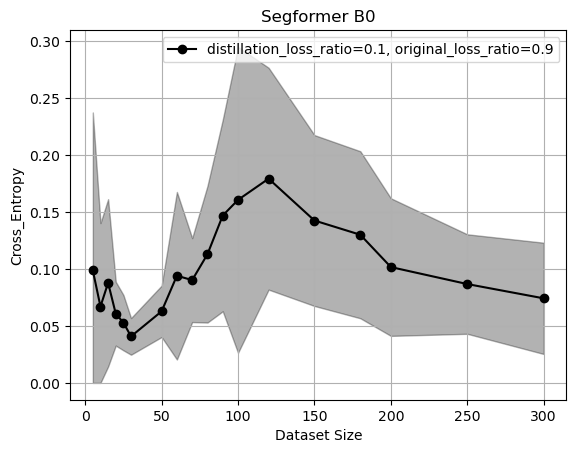

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0520')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.png"))

plt.show()